In [1]:
!pip install catboost

In [2]:
# 필수 라이브러리 import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno
from sklearn.preprocessing import StandardScaler

import gc

In [3]:
from google.colab import drive
drive.mount('/content/drive')

data_root = '/content/drive/MyDrive/Colab Notebooks/final_project/data/'
# data_path = data_root + 'train/'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

# 그래프 기본 설정
plt.rcParams['figure.figsize'] = 12, 6
plt.rcParams['font.size'] = 14
plt.rcParams['axes.unicode_minus'] = False
import matplotlib as mpl
import matplotlib.font_manager as fm

# 폰트 파일 경로 지정
font_path = '/content/drive/MyDrive/font/NanumGothic.ttf'

# 폰트 등록 및 matplotlib 설정
font_name = fm.FontProperties(fname=font_path).get_name()
fm.fontManager.addfont(font_path)
mpl.rc('font', family=font_name)

In [5]:
# pyarrow 설치 (parquet 파일 읽기용)
!pip install pyarrow

# 경고 뜨지 않게 설정
import warnings
warnings.filterwarnings('ignore')

In [6]:
# 데이터 로드: 6개월 청구정보 parquet 파일 병합
df41 = pd.read_parquet(data_root + 'train/4.청구입금정보/201807_train_청구정보.parquet')
df42 = pd.read_parquet(data_root + 'train/4.청구입금정보/201808_train_청구정보.parquet')
df43 = pd.read_parquet(data_root + 'train/4.청구입금정보/201809_train_청구정보.parquet')
df44 = pd.read_parquet(data_root + 'train/4.청구입금정보/201810_train_청구정보.parquet')
df45 = pd.read_parquet(data_root + 'train/4.청구입금정보/201811_train_청구정보.parquet')
df46 = pd.read_parquet(data_root + 'train/4.청구입금정보/201812_train_청구정보.parquet')

In [7]:
df4 = pd.concat([df41, df42, df43, df44, df45, df46])
print("병합 완료: ", df4.shape)

병합 완료:  (2400000, 46)


Backward Method(원본에서 불필요한 컬럼 제거)

In [29]:
# 결측치 처리
missing_cols = df4.columns[df4.isnull().any()]
missing_cols

Index([], dtype='object')

In [8]:
# 불필요한 컬럼 제거
cols_to_drop = ['대표결제방법코드', '청구서발송여부_R3M', '청구금액_R3M', '포인트_마일리지_환산_B0M']
df4.drop(columns=cols_to_drop, inplace=True, errors='ignore')
print("컬럼 제거 완료")

컬럼 제거 완료


In [9]:
# Segment 컬럼 가져오기
# parquet 파일 열기
df01 = pd.read_parquet(data_root + "train/1.회원정보/201807_train_회원정보.parquet")

In [10]:
df4 = df4.merge(df01[['ID', 'Segment']], on='ID', how='left')
df4

,기준년월,ID,대표결제일,대표청구지고객주소구분코드,대표청구서수령지구분코드,청구서수령방법,청구서발송여부_B0,청구서발송여부_R6M,청구금액_B0,청구금액_R6M,...,할인금액_청구서_B0M,상환개월수_결제일_R6M,상환개월수_결제일_R3M,선결제건수_R6M,선결제건수_R3M,연체건수_R6M,연체건수_R3M,혜택수혜금액_R3M,혜택수혜금액,Segment
0,201807,TRAIN_000000,27,미확인,당사페이앱+이메일,문자메세지,1,1,12226,88693,...,0,5,3,0,0,1,0,3,0,D
1,201807,TRAIN_000001,13,주거지,우편,우편,1,1,5834,16861,...,163,6,3,0,0,0,0,0,0,E
2,201807,TRAIN_000002,1,미확인,이메일,이메일,1,1,21866,165221,...,0,6,3,0,0,0,0,121,50,C
3,201807,TRAIN_000003,5,주거지,우편,우편,1,1,16356,127371,...,0,5,3,2,0,0,0,3,2,D
4,201807,TRAIN_000004,13,주거지,우편,우편,0,1,0,155,...,0,1,1,0,0,0,0,0,0,E
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2399995,201812,TRAIN_399995,25,주거지,우편,우편,0,0,0,0,...,0,0,0,0,0,0,0,0,0,E
2399996,201812,TRAIN_399996,20,미확인,이메일,이메일,1,1,14402,99849,...,0,6,3,0,0,0,0,164,53,D
2399997,201812,TRAIN_399997,20,회사,우편,우편,1,1,5731,41073,...,0,6,3,0,0,0,0,0,0,C
2399998,201812,TRAIN_399998,20,주거지,우편,우편,0,0,0,0,...,0,0,0,0,0,0,0,0,0,E


In [33]:
# 결측치 아니지만 값이 '미확인'
df4['대표청구지고객주소구분코드'].unique()
df4['대표청구지고객주소구분코드'].value_counts()

,count
대표청구지고객주소구분코드,
미확인,1123850
주거지,1023633
회사,252517


In [34]:
pivot_count = pd.crosstab(df4['Segment'], df4['대표청구지고객주소구분코드'])
pivot_count

대표청구지고객주소구분코드,미확인,주거지,회사
Segment,,,
A,537,293,142
B,96,30,18
C,73379,40977,13234
D,191668,124460,33114
E,858170,857873,206009


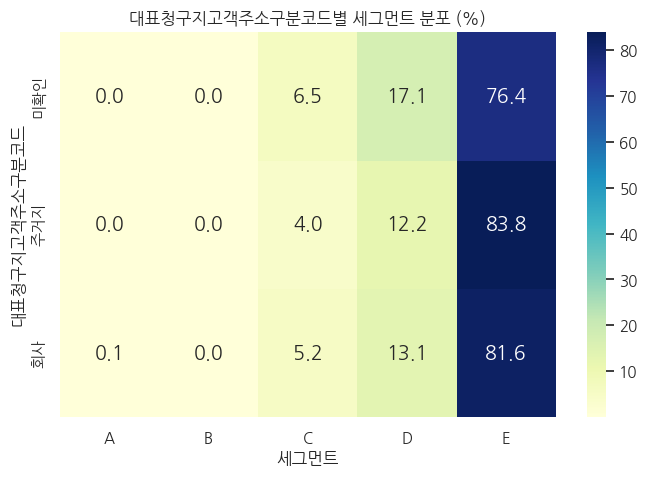

In [35]:
#  대표청구지고객주소구분코드별 세그먼트(cluster) 분포 비율 확인 (행 기준 정규화)
cross_tab = pd.crosstab(df4['대표청구지고객주소구분코드'], df4['Segment'], normalize='index') * 100

#  시각화
plt.figure(figsize=(8, 5))
sns.heatmap(cross_tab, annot=True, fmt='.1f', cmap='YlGnBu')
plt.title("대표청구지고객주소구분코드별 세그먼트 분포 (%)")
plt.xlabel("세그먼트")
plt.ylabel("대표청구지고객주소구분코드")
plt.show()

In [11]:
# '대표청구지고객주소구분코드' 컬럼 제거
df4.drop(columns=['대표청구지고객주소구분코드'], inplace=True, errors='ignore')

In [12]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400000 entries, 0 to 2399999
Data columns (total 42 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   기준년월              int64 
 1   ID                object
 2   대표결제일             int64 
 3   대표청구서수령지구분코드      object
 4   청구서수령방법           object
 5   청구서발송여부_B0        int64 
 6   청구서발송여부_R6M       int64 
 7   청구금액_B0           int64 
 8   청구금액_R6M          int64 
 9   포인트_마일리지_건별_B0M   int64 
 10  포인트_마일리지_건별_R3M   int64 
 11  포인트_포인트_건별_B0M    int64 
 12  포인트_포인트_건별_R3M    int64 
 13  포인트_마일리지_월적립_B0M  int64 
 14  포인트_마일리지_월적립_R3M  int64 
 15  포인트_포인트_월적립_B0M   int64 
 16  포인트_포인트_월적립_R3M   int64 
 17  포인트_적립포인트_R12M    int64 
 18  포인트_적립포인트_R3M     int64 
 19  포인트_이용포인트_R12M    int64 
 20  포인트_이용포인트_R3M     int64 
 21  포인트_잔여포인트_B0M     int64 
 22  마일_적립포인트_R12M     int64 
 23  마일_적립포인트_R3M      int64 
 24  마일_이용포인트_R12M     int64 
 25  마일_이용포인트_R3M      int64 
 26  마일_잔여포인트_B0M      int64 
 27  할인건수_R3M    

eda 및 피처 선택 이어서

1. VIF (다중공선성) 기준 피처 제거 코드 추가

In [13]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

# 수치형 컬럼만 선택
numeric_cols = df4.select_dtypes(include=['float64', 'int64']).columns.tolist()
X_vif = df4[numeric_cols].dropna()

# VIF 계산
vif_data = pd.DataFrame()
vif_data["Feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

# VIF가 10 이상인 피처 확인
high_vif_features = vif_data[vif_data["VIF"] > 10]["Feature"].tolist()
print("VIF > 10:", high_vif_features)

VIF > 10: ['기준년월', '포인트_마일리지_건별_B0M', '포인트_마일리지_건별_R3M', '포인트_포인트_건별_B0M', '포인트_포인트_건별_R3M', '포인트_마일리지_월적립_B0M', '포인트_마일리지_월적립_R3M', '포인트_적립포인트_R3M', '포인트_이용포인트_R3M', '마일_적립포인트_R12M', '마일_적립포인트_R3M', '마일_이용포인트_R12M', '마일_이용포인트_R3M', '할인금액_R3M', '할인금액_B0M', '할인금액_청구서_R3M', '할인금액_청구서_B0M', '상환개월수_결제일_R6M', '상환개월수_결제일_R3M', '혜택수혜금액_R3M', '혜택수혜금액']


In [14]:
# 1. 기준년월 컬럼을 제외한 VIF 10 이상 컬럼만 제거 대상에 포함
features_to_drop = [col for col in high_vif_features if col != '기준년월']

# 2. 컬럼 제거
df4 = df4.drop(columns=features_to_drop)
print("제거된 컬럼 목록:", features_to_drop)

제거된 컬럼 목록: ['포인트_마일리지_건별_B0M', '포인트_마일리지_건별_R3M', '포인트_포인트_건별_B0M', '포인트_포인트_건별_R3M', '포인트_마일리지_월적립_B0M', '포인트_마일리지_월적립_R3M', '포인트_적립포인트_R3M', '포인트_이용포인트_R3M', '마일_적립포인트_R12M', '마일_적립포인트_R3M', '마일_이용포인트_R12M', '마일_이용포인트_R3M', '할인금액_R3M', '할인금액_B0M', '할인금액_청구서_R3M', '할인금액_청구서_B0M', '상환개월수_결제일_R6M', '상환개월수_결제일_R3M', '혜택수혜금액_R3M', '혜택수혜금액']


In [15]:
# 기준년월이 여전히 남아있는지 확인
print("'기준년월' in df4.columns:", '기준년월' in df4.columns)

'기준년월' in df4.columns: True


2. 10만 개 stratified 샘플 기반 피처 중요도 분석

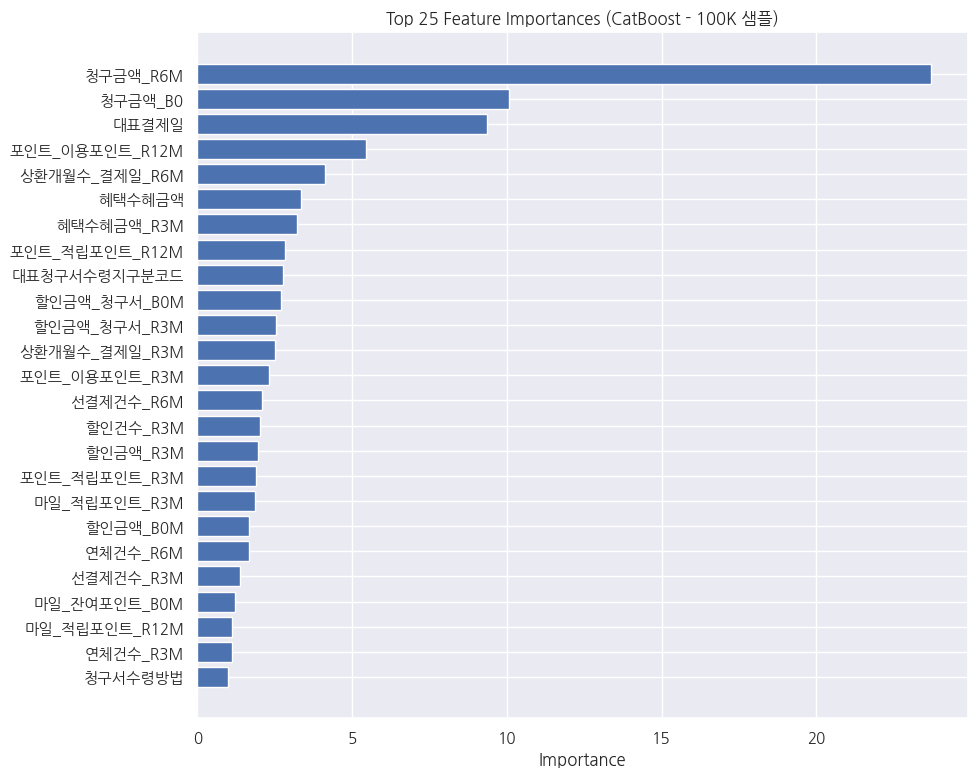

In [41]:
# 1. 파일 불러오기 (SMOTE 후 50만 샘플 데이터)
import pandas as pd

df_smote = pd.read_parquet("/content/drive/MyDrive/Colab Notebooks/final_project/final_sampling/train4_smote_500k.parquet")

# 2. X, y 분리
X_sampled = df_smote.drop(columns=["Segment"])
y_sampled = df_smote["Segment"]

# 3. Stratified 샘플링 10만 개
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=100_000, random_state=42)
for sample_idx, _ in sss.split(X_sampled, y_sampled):
    X_100K = X_sampled.iloc[sample_idx].copy()
    y_100K = y_sampled.iloc[sample_idx].copy()

# 4. 범주형 컬럼 처리
cat_cols = X_100K.select_dtypes(include=['object', 'category']).columns.tolist()
for col in cat_cols:
    X_100K[col] = X_100K[col].astype('category')

# 5. CatBoost로 학습 및 feature importance 시각화
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt

cat_model = CatBoostClassifier(verbose=0, random_state=42, cat_features=cat_cols)
cat_model.fit(X_100K, y_100K)

# 중요도 시각화
importances = pd.DataFrame({
    "Feature": X_100K.columns,
    "Importance": cat_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 8))
plt.barh(importances["Feature"][:25][::-1], importances["Importance"][:25][::-1])
plt.title("Top 25 Feature Importances (CatBoost - 100K 샘플)")
plt.xlabel("Importance")
plt.grid(True)
plt.tight_layout()
plt.show()


1. 상위 주요 피처
- '청구금액_R6M', '청구금액_B0', '대표결제일' -> Segment 구분에 큰 영향
2. 중간 중요도
- '포인트_이용포인트_R12M', '상환개월수_결제일_R6M', '혜택수혜금액'
3. 영향도 매우 낮음(제거 후보군)
- '마일_잔여포인트_B0M' ~ '청구서수령방법'

고객이 최근 6개월, 당월 기준으로 청구/결제/포인트 사용 내역이 세그먼트를 나누는 주요 기준으로 작용

→ 소비 패턴 및 혜택 활용도가 주요 세분화 기준이라는 해석 가능

In [43]:
# Stratified 샘플 10만 개 저장
X_100K.to_parquet("/content/drive/MyDrive/Colab Notebooks/final_project/final_sampling/4X_100K.parquet", index=False)
y_100K.to_frame().to_parquet("/content/drive/MyDrive/Colab Notebooks/final_project/final_sampling/4y_100K.parquet", index=False)

In [44]:
# feature importance 저장
import pickle

# 저장
with open("/content/drive/MyDrive/Colab Notebooks/final_project/final_sampling/4_catboost_feature_importance.pkl", "wb") as f:
    pickle.dump(cat_model.get_feature_importance(prettified=True), f)

# 불러오기
with open("/content/drive/MyDrive/Colab Notebooks/final_project/final_sampling/4_catboost_feature_importance.pkl", "rb") as f:
    feature_importance = pickle.load(f)

저장한 10만 개 샘플 불러오기

In [16]:
X_100K = pd.read_parquet("/content/drive/MyDrive/Colab Notebooks/final_project/final_sampling/4X_100K.parquet")
y_100K = pd.read_parquet("/content/drive/MyDrive/Colab Notebooks/final_project/final_sampling/4y_100K.parquet").squeeze()

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from catboost import CatBoostClassifier

In [17]:
# 저장된 smote 샘플 데이터 = df_smote
# 라벨, 피처 분리 = X_sampled, y_sampled
# Stratified 샘플링 10만 개 = sss
# 상위 25개 중요 피처 리스트 (앞서 시각화 결과 기반)
top25_features = [
    '청구금액_R6M', '청구금액_B0', '대표결제일', '포인트_이용포인트_R12M', '상환개월수_결제일_R6M',
    '혜택수혜금액', '혜택수혜금액_R3M', '포인트_적립포인트_R12M', '대표청구서수령지구분코드',
    '할인금액_청구서_B0M', '할인금액_청구서_R3M', '상환개월수_결제일_R3M', '포인트_이용포인트_R3M',
    '선결제건수_R6M', '할인건수_R3M', '할인금액_R3M', '포인트_적립포인트_R3M', '마일_적립포인트_R3M',
    '할인금액_B0M', '연체건수_R6M', '선결제건수_R3M', '마일_잔여포인트_B0M',
    '마일_적립포인트_R12M', '연체건수_R3M', '청구서수령방법'
]

# 상위 25개 피처 선택
X_100K_top = X_100K[top25_features]

# 범주형 컬럼 처리 (CatBoost용)
cat_cols = X_100K_top.select_dtypes(include='object').columns.tolist()
for col in cat_cols:
    X_100K_top[col] = X_100K_top[col].astype('category')

# 학습/검증 분리
X_train, X_val, y_train, y_val = train_test_split(
    X_100K_top, y_100K, test_size=0.2, random_state=42, stratify=y_100K
)

# 모델 학습
cat_model = CatBoostClassifier(verbose=0, random_state=42, cat_features=cat_cols)
cat_model.fit(X_train, y_train)
cat_preds = cat_model.predict(X_val)

# 평가
print("CatBoost Accuracy (Top 25 Features):", accuracy_score(y_val, cat_preds))
print("\nCatBoost Classification Report (Top 25 Features)")
print(classification_report(y_val, cat_preds))

NameError: name 'train_test_split' is not defined

- C의 precision은 높지만 recall이 0.67 → C로 잘못 예측된 다른 클래스 존재

- E는 recall이 높고 precision이 낮아 → 다른 클래스에서 E로 많이 예측됨

In [18]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400000 entries, 0 to 2399999
Data columns (total 22 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   기준년월             int64 
 1   ID               object
 2   대표결제일            int64 
 3   대표청구서수령지구분코드     object
 4   청구서수령방법          object
 5   청구서발송여부_B0       int64 
 6   청구서발송여부_R6M      int64 
 7   청구금액_B0          int64 
 8   청구금액_R6M         int64 
 9   포인트_포인트_월적립_B0M  int64 
 10  포인트_포인트_월적립_R3M  int64 
 11  포인트_적립포인트_R12M   int64 
 12  포인트_이용포인트_R12M   int64 
 13  포인트_잔여포인트_B0M    int64 
 14  마일_잔여포인트_B0M     int64 
 15  할인건수_R3M         object
 16  할인건수_B0M         object
 17  선결제건수_R6M        int64 
 18  선결제건수_R3M        int64 
 19  연체건수_R6M         int64 
 20  연체건수_R3M         int64 
 21  Segment          object
dtypes: int64(16), object(6)
memory usage: 402.8+ MB


In [19]:
# Parquet 저장(세그먼트 포함)
df4.to_parquet("train_4번eda_withSegment.parquet", index=False)

# 파일 다운로드
from google.colab import files
files.download("train_4번eda_withSegment.parquet")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [20]:
# Segment 컬럼 분리
df4_segment = df4['Segment']

# df4에서 Segment 컬럼 제거
df44 = df4.drop(columns=['Segment'])

print("df4에서 Segment 컬럼이 제거되었습니다.")
print("\n분리된 Segment 데이터프레임:")
print(df4_segment.head())
print("\nSegment 제거 후 df4:")
print(df44.head())

df4에서 Segment 컬럼이 제거되었습니다.

분리된 Segment 데이터프레임:
0    D
1    E
2    C
3    D
4    E
Name: Segment, dtype: object

Segment 제거 후 df4:
     기준년월            ID  대표결제일 대표청구서수령지구분코드 청구서수령방법  청구서발송여부_B0  청구서발송여부_R6M  \
0  201807  TRAIN_000000     27    당사페이앱+이메일   문자메세지           1            1   
1  201807  TRAIN_000001     13           우편      우편           1            1   
2  201807  TRAIN_000002      1          이메일     이메일           1            1   
3  201807  TRAIN_000003      5           우편      우편           1            1   
4  201807  TRAIN_000004     13           우편      우편           0            1   

   청구금액_B0  청구금액_R6M  포인트_포인트_월적립_B0M  ...  포인트_적립포인트_R12M  포인트_이용포인트_R12M  \
0    12226     88693                0  ...            3460            4008   
1     5834     16861                0  ...               0               0   
2    21866    165221                0  ...           17135            8312   
3    16356    127371                0  ...            6464            8815  

Parquet 저장 및 다운로드

In [51]:
# Parquet 저장
df44.to_parquet("train_4번eda.parquet", index=False)

# 파일 다운로드
from google.colab import files
files.download("train_4번eda.parquet")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

인코딩

In [52]:
from sklearn.preprocessing import LabelEncoder

# 범주형 컬럼 확인 및 인코딩
categorical_cols = df44.select_dtypes(include=['object', 'category']).columns

# Label Encoding 수행
for col in categorical_cols:
    le = LabelEncoder()
    df44[col] = le.fit_transform(df44[col].astype(str)) # 결측치 등을 문자열 'nan'으로 처리하여 인코딩

print("범주형 컬럼 인코딩 완료")

# Parquet 저장
df44.to_parquet("train_4번eda_encoded.parquet", index=False)

# 파일 다운로드
from google.colab import files
files.download("train_4번eda_encoded.parquet")


범주형 컬럼 인코딩 완료


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [54]:
# 가비지 컬렉션 실행
gc.collect()

30

상관관계, 카이제곱

1. 수치형 변수 간 상관관계 히트맵 코드

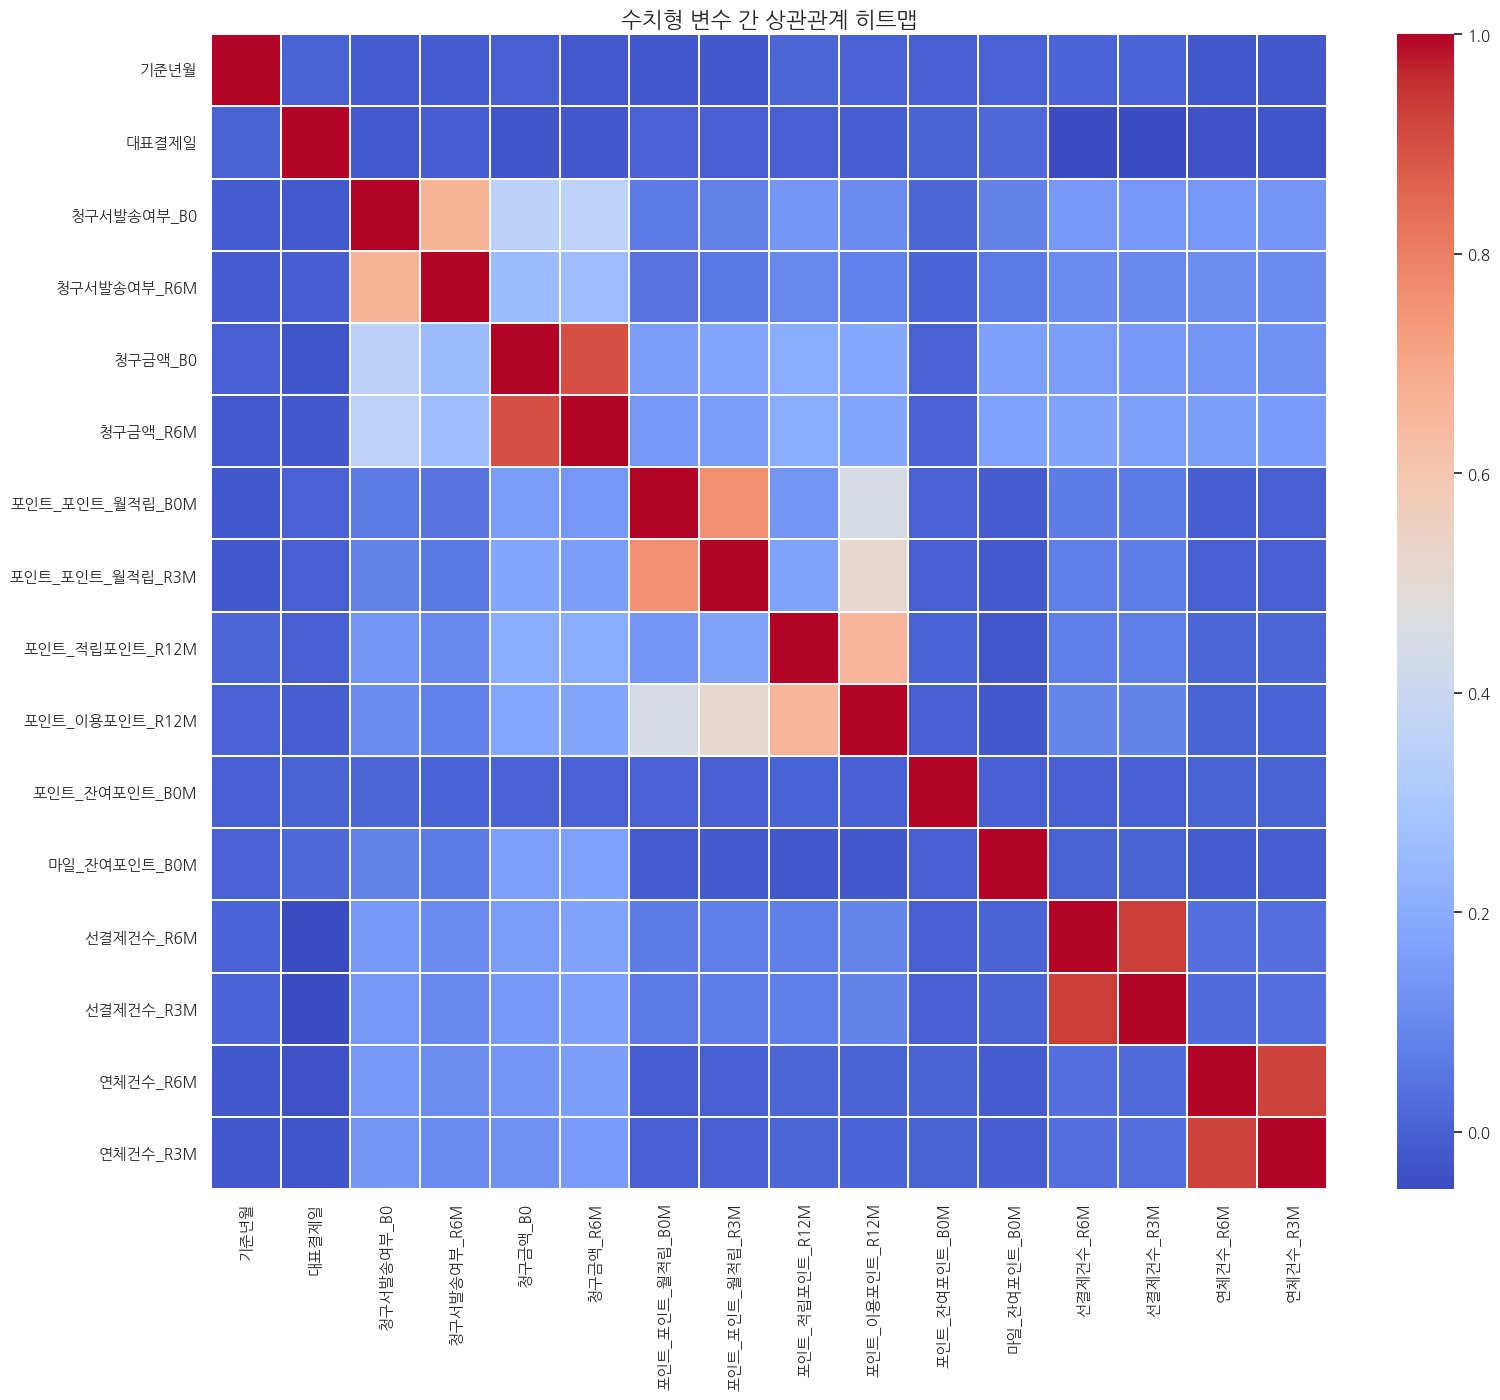

In [55]:
# 데이터 불러오기
df = pd.read_parquet("/content/drive/MyDrive/Colab Notebooks/final_project/final_eda/train_4번eda.parquet")

# 수치형 변수만 선택
numeric_df = df.select_dtypes(include=['int64', 'float64'])

# 상관계수 행렬 계산
corr_matrix = numeric_df.corr()

# 히트맵 시각화
plt.figure(figsize=(18, 15))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, fmt=".2f", linewidths=0.3)
plt.title("수치형 변수 간 상관관계 히트맵", fontsize=16)
plt.show()

1. 포인트 관련 변수 간 강한 양의 상관관계
- 포인트_포인트_월적립_R3M, 포인트_포인트_월적립_B0M
- 포인트_적립포인트_R12M ↔ 포인트_이용포인트_R12M
-> 비슷한 개념의 기간별 누적/월간 포인트 사용 및 적립 변수 간 상관 높음
-> 중복정보 가능성 있어 PCA나 변수 선택 시 한쪽 제거 고려 가능

2. 청구 관련 변수 간 중간 이상 상관
- 청구금액_B0 ↔ 청구금액_R6M, 청구서발송여부_B0
→ 최근 청구 금액과 과거 청구 금액, 서류 발송 여부 간 연관이 있음을 시사
→ 청구 관련 변수들을 그룹핑해서 해석 가능

3. 연체/선결제 관련 변수들 간 상관
- 선결제건수_R6M ↔ 선결제건수_R3M, 연체건수_R3M ↔ 연체건수_R6M
→ 기간만 다른 같은 성격의 변수끼리 높은 상관 → VIF에도 영향 줄 수 있음

In [56]:
# 상관계수 테이블 확인
corr_matrix = df.select_dtypes(include=['float64', 'int64']).corr()

# 절대 상관관계가 0.7 이상인 컬럼 쌍 필터링
high_corr = corr_matrix.abs().unstack().sort_values(ascending=False)
high_corr = high_corr[high_corr < 1.0]  # 자기 자신 제외
high_corr = high_corr[high_corr > 0.7].drop_duplicates()

print("상관계수 0.7 초과 컬럼 쌍:")
display(high_corr)

상관계수 0.7 초과 컬럼 쌍:


,,0
선결제건수_R3M,선결제건수_R6M,0.930869
연체건수_R6M,연체건수_R3M,0.924025
청구금액_B0,청구금액_R6M,0.897863
포인트_포인트_월적립_R3M,포인트_포인트_월적립_B0M,0.761428


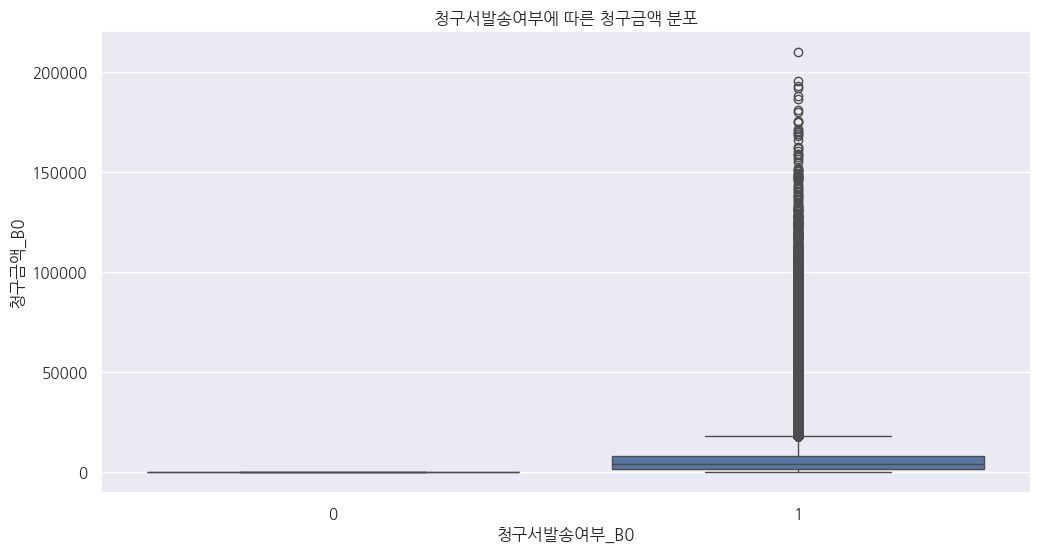

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x='청구서발송여부_B0', y='청구금액_B0', data=df)
plt.title('청구서발송여부에 따른 청구금액 분포')
plt.show()


- 청구서발송여부가 1인 그룹(청구서 받은)의 청구금액이 확연히 크고, 분포도 넓게 퍼짐.
=> 청구서를 받는 고객은 대부분 실제로 금액을 청구받고 있고, 청구 금액이 클수록 청구서를 받는 비율이 높다고도 볼 수 있음.

카이제곱 검정(Segment vs 범주형 변수)

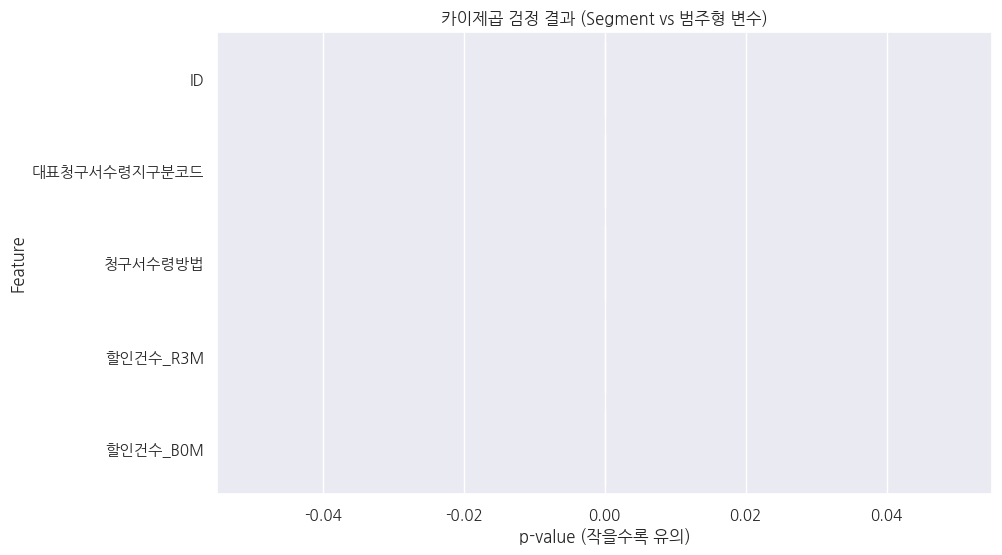


 유의미한 범주형 변수 목록 (p < 0.05)
        Feature          Chi2  p-value
0            ID  9.600000e+06      0.0
1  대표청구서수령지구분코드  2.303897e+04      0.0
2       청구서수령방법  2.303872e+04      0.0
3      할인건수_R3M  1.696892e+05      0.0
4      할인건수_B0M  2.170560e+04      0.0


In [24]:
from scipy.stats import chi2_contingency

# 범주형 컬럼만 추출 (Segment 제외)
categorical_cols = df4.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
categorical_cols = [col for col in categorical_cols if col != 'Segment']

chi2_results = []

for col in categorical_cols:
    # 교차표 생성
    contingency = pd.crosstab(df4[col], df4['Segment'])

    # 카이제곱 검정 수행
    chi2, p, dof, expected = chi2_contingency(contingency)

    chi2_results.append({
        'Feature': col,
        'Chi2': chi2,
        'p-value': p
    })

# 결과 정리
chi2_df = pd.DataFrame(chi2_results).sort_values(by='p-value')
import seaborn as sns
import matplotlib.pyplot as plt

# 시각화
plt.figure(figsize=(10,6))
sns.barplot(data=chi2_df, x='p-value', y='Feature', palette='coolwarm')
plt.title('카이제곱 검정 결과 (Segment vs 범주형 변수)')
plt.xlabel('p-value (작을수록 유의)')
plt.show()

# 유의한 변수 확인 (p < 0.05 기준)
print("\n 유의미한 범주형 변수 목록 (p < 0.05)")
print(chi2_df[chi2_df['p-value'] < 0.05])


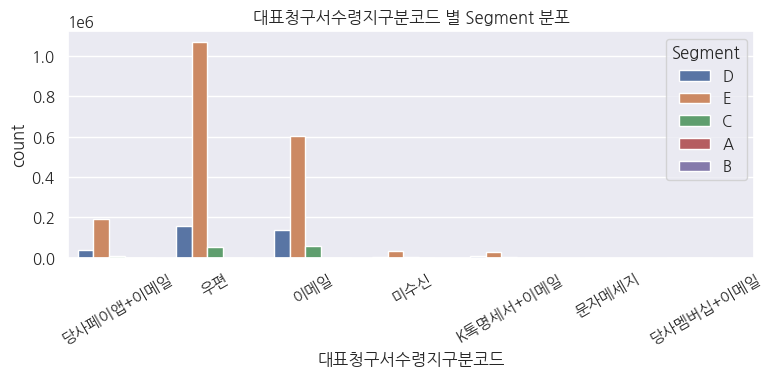

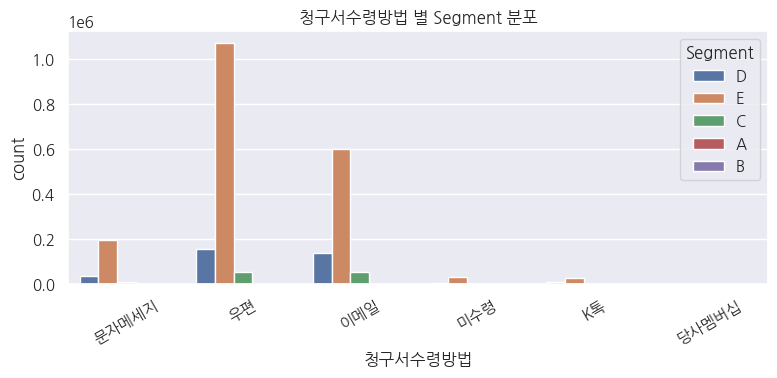

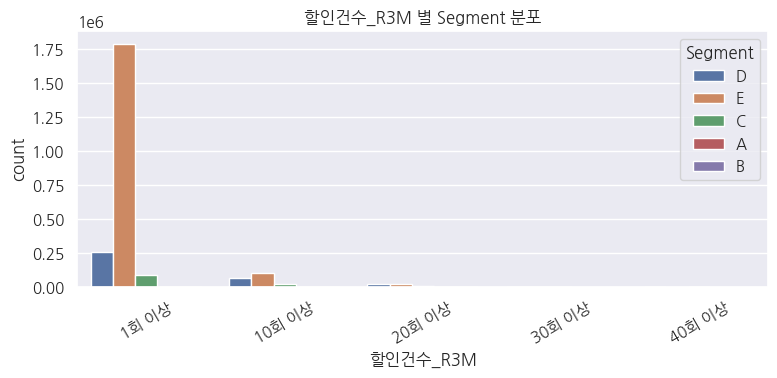

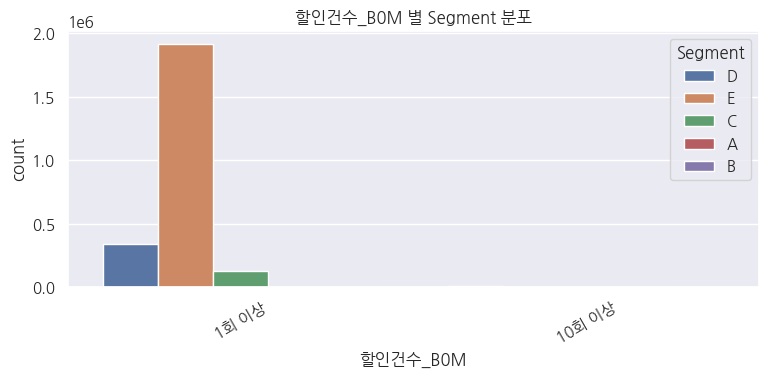

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

# 범주형 변수 목록
cat_features = ['대표청구서수령지구분코드', '청구서수령방법', '할인건수_R3M', '할인건수_B0M']

for col in cat_features:
    plt.figure(figsize=(8,4))
    sns.countplot(data=df4, x=col, hue='Segment')
    plt.title(f"{col} 별 Segment 분포")
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()

- 청구서 수령 관련 변수 및 할인건수 변수는 Segment E를 중심으로 특성이 명확히 드러남 → 중요 피처로 유지

PCA

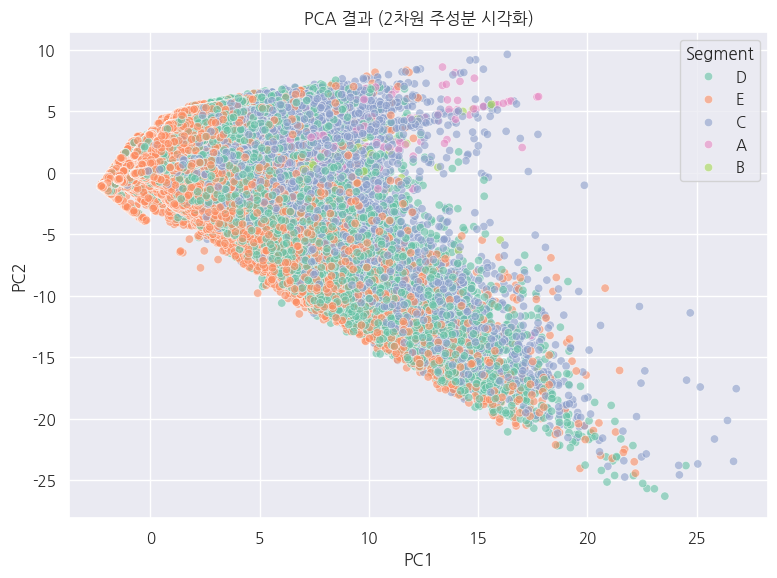

PC1 설명력: 21.11%, PC2 설명력: 14.26%


In [27]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# 수치형 변수만 선택
numeric_cols = df4.select_dtypes(include=['int64', 'float64']).columns.tolist()

# 라벨 변수 ('Segment') 분리
X_pca = df4[numeric_cols].drop(columns=['ID', '기준년월'], errors='ignore')
y_pca = df4['Segment'] if 'Segment' in df4.columns else None  # 있으면 활용

# 결측치 제거
X_pca = X_pca.dropna()

# 정규화 (스케일링)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_pca)

# PCA 수행
pca = PCA(n_components=2)
X_pca_2d = pca.fit_transform(X_scaled)

# 결과 DataFrame
pca_df = pd.DataFrame(X_pca_2d, columns=['PC1', 'PC2'])
if y_pca is not None:
    pca_df['Segment'] = y_pca.iloc[X_pca.index].values  # 인덱스 정렬 맞추기

# 시각화
plt.figure(figsize=(8,6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Segment', palette='Set2', alpha=0.6)
plt.title('PCA 결과 (2차원 주성분 시각화)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title='Segment')
plt.grid(True)
plt.tight_layout()
plt.show()

# 각 주성분 설명력
explained_var = pca.explained_variance_ratio_
print(f"PC1 설명력: {explained_var[0]:.2%}, PC2 설명력: {explained_var[1]:.2%}")

- PC1 설명력: 21.11% / PC2 설명력: 14.26% → 누적 35.37%

- 설명력이 다소 낮으므로 PCA 자체는 피처 제거의 결정적 기준은 되기 어렵고, 참고용으로 활용

ANOVA 분석과 Boxplot 시각화(수치형 변수와 Segment 간의 관계를 파악)

In [30]:
#1. ANOVA 분석 코드 (수치형 변수 vs Segment)
import pandas as pd
import scipy.stats as stats

# 수치형 변수 추출
numeric_cols = df4.select_dtypes(include=['float64', 'int64']).columns.tolist()

# ANOVA 결과 저장용 리스트
anova_results = []

# 수치형 변수별 ANOVA 검정 수행
for col in numeric_cols:
    groups = [group[col].dropna().values for name, group in df4.groupby('Segment')]
    f_val, p_val = stats.f_oneway(*groups)
    anova_results.append({'Feature': col, 'F-value': f_val, 'p-value': p_val})

# 데이터프레임 변환 후 유의한 결과 필터링
anova_df = pd.DataFrame(anova_results)
anova_df = anova_df.sort_values(by='p-value')

# 유의미한 피처만 출력 (p < 0.05)
significant_anova = anova_df[anova_df['p-value'] < 0.05]
print("유의미한 수치형 변수 목록 (p < 0.05)")
display(significant_anova)


유의미한 수치형 변수 목록 (p < 0.05)


,Feature,F-value,p-value
3,청구서발송여부_R6M,16623.706606,0.000000e+00
2,청구서발송여부_B0,31425.121957,0.000000e+00
5,청구금액_R6M,337197.622068,0.000000e+00
4,청구금액_B0,304386.662425,0.000000e+00
6,포인트_포인트_월적립_B0M,8677.202886,0.000000e+00
7,포인트_포인트_월적립_R3M,10384.182809,0.000000e+00
9,포인트_이용포인트_R12M,13492.169077,0.000000e+00
8,포인트_적립포인트_R12M,19976.693273,0.000000e+00
14,연체건수_R6M,2599.497177,0.000000e+00
13,선결제건수_R3M,14340.168323,0.000000e+00


In [32]:
# 유의미한 수치형 변수 리스트 (p < 0.05 기준)
significant_numeric_features = [
    '청구서발송여부_R6M',
    '청구서발송여부_B0',
    '청구금액_R6M',
    '청구금액_B0',
    '포인트_포인트_월적립_B0M',
    '포인트_포인트_월적립_R3M',
    '포인트_이용포인트_R12M',
    '포인트_적립포인트_R12M',
    '연체건수_R6M',
    '선결제건수_R3M',
    '마일_잔여포인트_B0M',
    '선결제건수_R6M',
    '연체건수_R3M',
    '대표결제일',
    '포인트_잔여포인트_B0M'
]

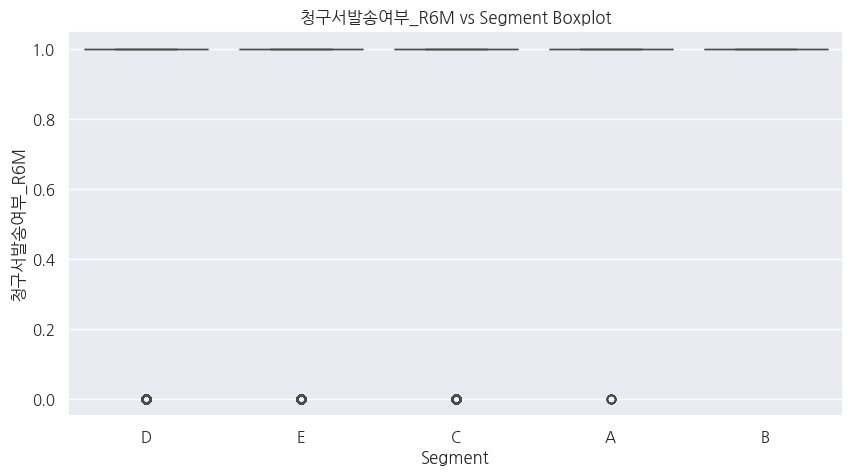

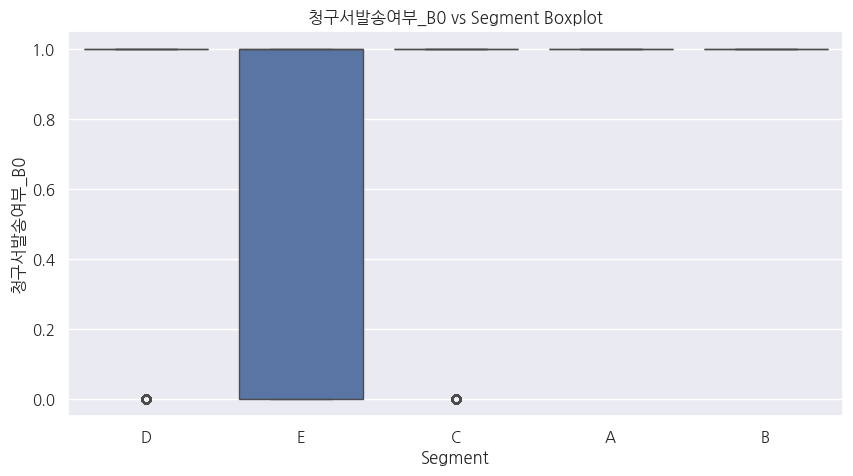

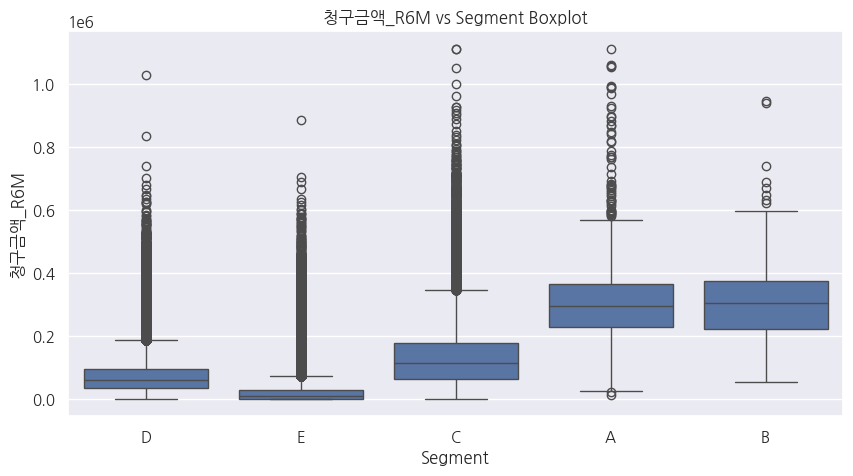

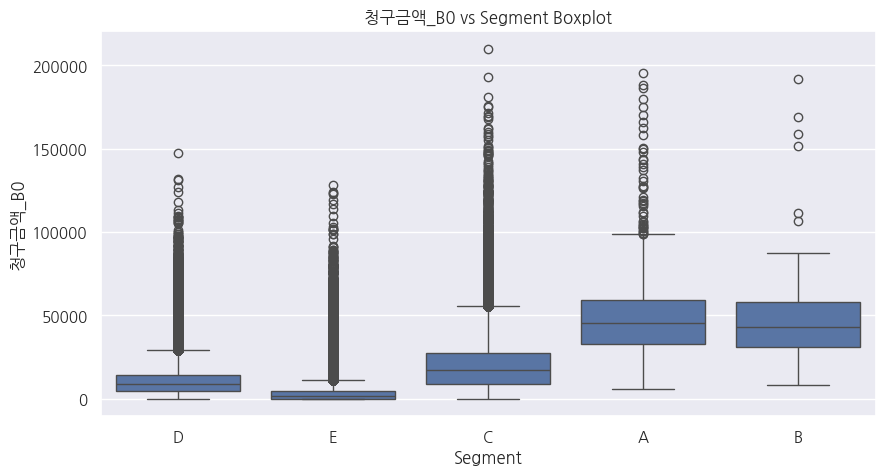

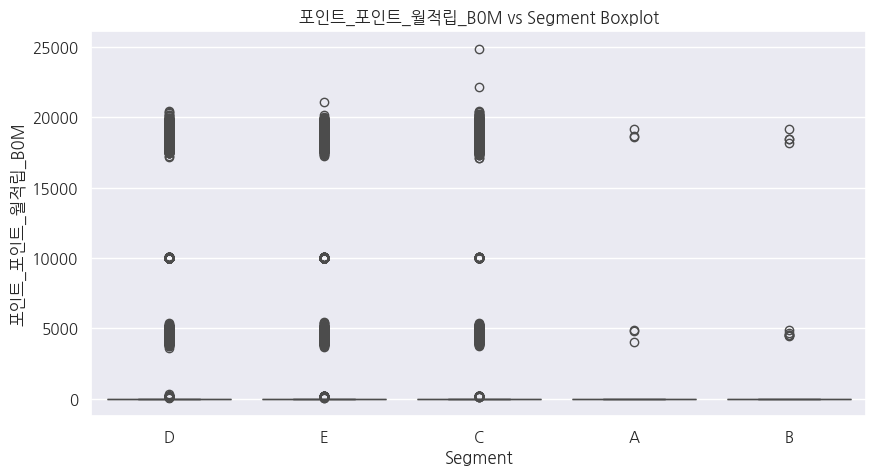

In [31]:
#2. Boxplot 시각화 코드 (상위 5개 유의 변수 예시)
import seaborn as sns
import matplotlib.pyplot as plt

# 상위 5개 유의미 변수만 시각화
top5_anova_features = significant_anova['Feature'].head(5).tolist()

for col in top5_anova_features:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x='Segment', y=col, data=df4)
    plt.title(f'{col} vs Segment Boxplot')
    plt.show()

- 청구서발송여부_B0, 청구서발송여부_R6M: Segment E가 거의 100% ‘1’ 값을 가짐. → Segment E는 청구서를 거의 다 수신하는 특성이 있음.

- 청구금액_R6M, 청구금액_B0: Segment A, B가 평균적으로 더 높은 청구금액을 보이며, E는 낮음. → 소비 규모가 세그먼트와 상관관계 있음.

- 포인트_포인트_월적립_B0M: A, B 세그먼트에서는 거의 0, 반면 C, D, E 세그먼트에서 값이 존재. → A, B는 포인트 적립을 잘 하지 않는 특징.

 Boxplot 해석
- 여러 피처의 분포를 보면 세그먼트 간 평균 및 분산 차이가 명확하게 나타남
- 특히 청구금액 계열 변수, 포인트 계열 변수, 연체·선결제 관련 변수들이 세그먼트별 특징을 분명히 구분하는 데 기여
-  청구금액_*, 포인트_적립포인트_*, 청구서발송여부_*는 모두 세그먼트 구분에서 핵심적인 역할을 하므로 모델 학습에 포함하는 것이 매우 유효.

반대로, 세그먼트 간 분포 차이가 거의 없거나, 분산이 너무 작아 정보가 적은 피처는 제거를 고려.

In [ ]:
# # parquet 파일 열기
# df1 = pd.read_parquet("201807_train_청구정보.parquet")

# # csv로 저장
# df1.to_csv("201807_train_청구정보.csv", index=False)
